In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import py_wake
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math


from py_wake.wind_farm_models import All2AllIterative
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.site._site import UniformSite
from py_wake.flow_map import XYGrid
from py_wake.flow_map import XZGrid
from py_wake.flow_map import YZGrid
from py_wake.turbulence_models import CrespoHernandez
from py_wake.turbulence_models import GCLTurbulence
from py_wake.deficit_models import Rathmann
from py_wake.utils.plotting import setup_plot

from py_wake.site import UniformWeibullSite

from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine

from py_wake.deficit_models.gaussian import BlondelSuperGaussianDeficit2020
from py_wake.literature.gaussian_models import Blondel_Cathelain_2020

from scipy.optimize import differential_evolution
from scipy.optimize import dual_annealing
from sko.GA import GA


import h5py
import xarray as xr

import time


In [2]:
#turbine parameters
D = 283.21 #rotor diameter
H=170 #hub height
Prated=22000 #kW

WD=270  #wind direction
WS=9 #wind speed
YD=0   #yaw direction
TI=0   #turbulence intensity


#site
site= UniformWeibullSite(p_wd=[0.03597152, 0.03948682, 0.05167394999999999, 0.07000154, 0.08364547,0.0643485,0.08643194,0.1177051,0.1515757, 0.14737920000000002, 0.1001205 , 0.1001205],  # sector frequencies
                               a=[9.176929, 9.782334, 9.531809,9.909545, 10.04269, 9.593921, 9.584007, 10.51499, 11.39895, 11.68746,11.63732,10.08803],          # Weibull scale parameter
                               k=[ 2.392578,2.447266,2.412109,2.591797, 2.755859, 2.595703, 2.583984,2.548828, 2.470703,2.607422, 2.626953, 2.326172],          # Weibull shape parameter
                               ti=TI                          # turbulence intensity, optional
                               )



from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

#curves from openfast
u=[3,4.06,5,6.15,7.16,8.18,9.027,10.21,11.17,12.26,13.47,14.1,15.47,16.19,17.67,18.44,19.23,20.03,21.66,22.5,23.3,24.16,25]
ct=[0.88,0.8843,0.8828,0.887,0.8872,0.8899,0.89,0.8,0.58,0.406,0.2933,0.2518,0.1835,0.1572,0.1173,0.1033,0.0913,0.0811,0.0649,0.0583,0.0529,0.0479,0.0437]
power=[474,1176,2194,4094,6414,9562,12840,19310,22000,22000,22000,22000,22000,22000,22000,22000,22000,22000,22000,22000,22000,22000,22000]

windTurbines = WindTurbine(name='MyWT',
                    diameter=D,
                    hub_height=H,
                    powerCtFunction=PowerCtTabular(u,power,'kW',ct))

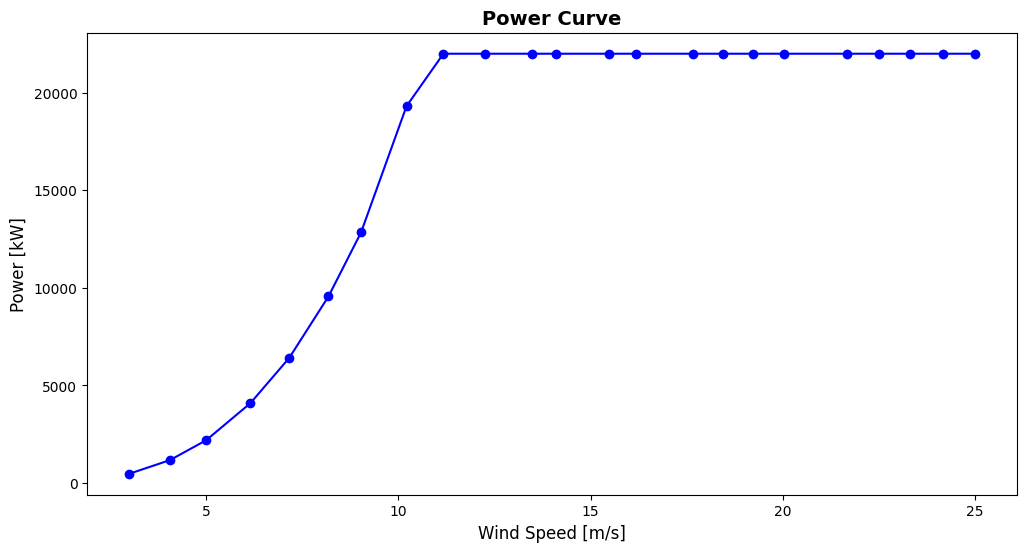

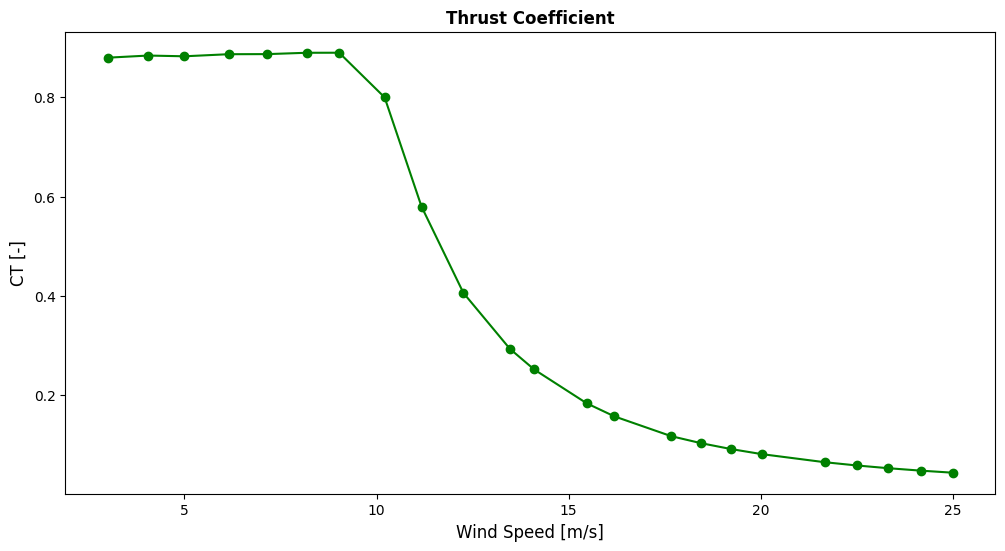

In [19]:


# Plotting the power curve
plt.figure(figsize=(12, 6))
plt.plot(u, power, label='Power Curve', color='blue', marker='o')
plt.xlabel('Wind Speed [m/s]',fontsize=12)
plt.ylabel('Power [kW]',fontsize=12)
plt.title('Power Curve',fontsize=14,fontweight='bold')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(u, ct, label='Thrust Coefficient', color='green', marker='o')
plt.xlabel('Wind Speed [m/s]',fontsize=12)
plt.ylabel('CT [-]',fontsize=12)
plt.title('Thrust Coefficient',fontsize=12,fontweight='bold')

plt.show()


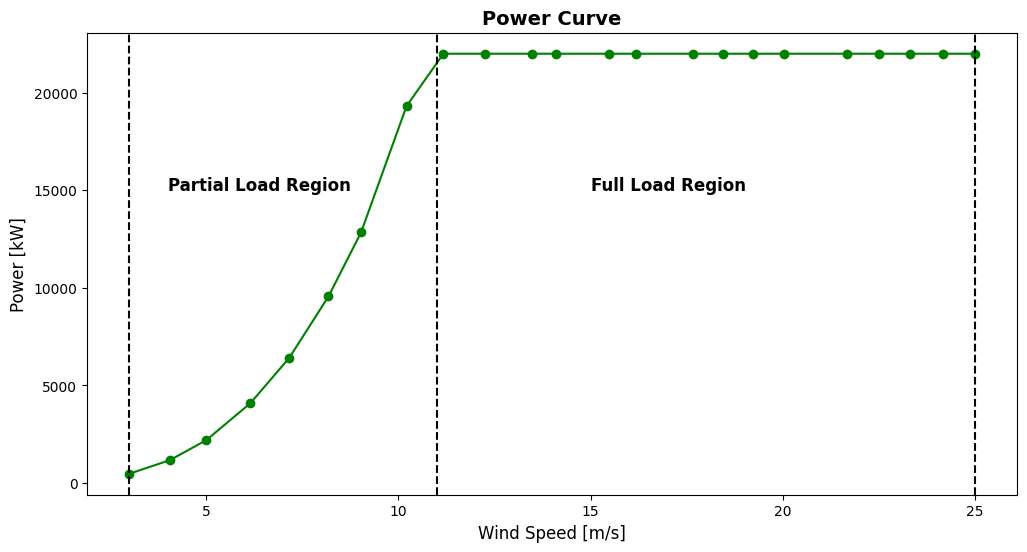

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(u, power, label='Power Curve', color='green', marker='o')

# Add vertical lines at x = 3, 11, and 25
plt.axvline(x=3, color='black', linestyle='--', label='x = 3')
plt.axvline(x=11, color='black', linestyle='--', label='x = 11')
plt.axvline(x=25, color='black', linestyle='--', label='x = 25')
plt.text(4, 15000, "Partial Load Region", fontsize=12, fontweight='bold', color='black')
plt.text(15, 15000, "Full Load Region", fontsize=12, fontweight='bold', color='black')
plt.xlabel('Wind Speed [m/s]', fontsize=12)
plt.ylabel('Power [kW]', fontsize=12)
plt.title('Power Curve', fontsize=14, fontweight='bold')



plt.show()

In [3]:
simulation_data_xy = np.loadtxt('101_IEA22MW_baseline_new_xy.txt')  #put respective LES



In [4]:
def get_velocity_field_xy(model=None, grid=XYGrid(x=np.linspace(0, 4400, 440), y=np.linspace(-1400 ,1400, 280), h=H)):
    wfm = All2AllIterative(site, windTurbines, wake_deficitModel=model,blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
    result = wfm(x=[0], y=[0], wd=WD, ws=WS, yaw=YD).flow_map(grid)
    return result.WS_eff.values.squeeze()


c:\Users\asus\anaconda3\envs\pywakeEnv\Lib\site-packages\py_wake\deficit_models\gaussian.py:540: RuntimeWarning: invalid value encountered in sqrt
  deficit_center_ijlk = a1 - np.sqrt(a2 - ((n * ctx_ijlk) / (16.0 * gamma(2 / n) * np.sign(sigma_ijlk) *
C:\Users\asus\AppData\Local\Temp\ipykernel_25424\1831701489.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels((x_ticks * 10).astype(int))
C:\Users\asus\AppData\Local\Temp\ipykernel_25424\1831701489.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels((y_ticks * 10).astype(int))


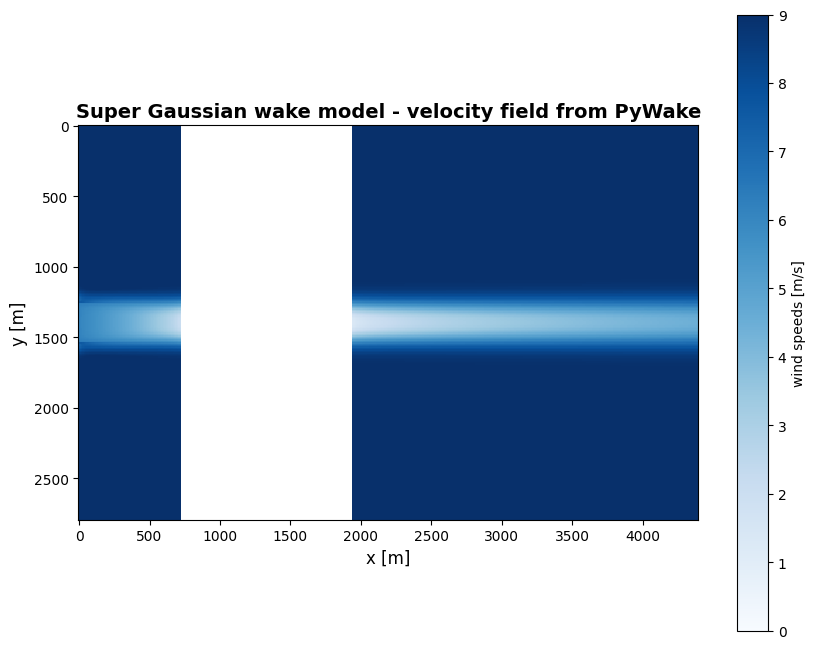

In [5]:

wf_model= BlondelSuperGaussianDeficit2020()
wf_model2=Blondel_Cathelain_2020(site,windTurbines,turbulenceModel=GCLTurbulence())

effective_velocity_standard_xy=get_velocity_field_xy(wf_model)
bias1_xy=effective_velocity_standard_xy-simulation_data_xy



sim_res = wf_model2(x=[0], y=[0],     # wind turbine positions
                   h=H,   # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0,   # Wind turbine types
                   wd=WD,  # Wind direction
                   ws=WS,  # Wind speed
                  )

CT=sim_res.CT.values.squeeze()

fig = plt.figure(figsize=(10, 8))
im=plt.imshow(effective_velocity_standard_xy, cmap='Blues', interpolation='nearest', vmin=0, vmax=WS)
plt.colorbar(im, label='wind speeds [m/s]')
plt.title(f'Super Gaussian wake model - velocity field from PyWake', fontsize=14, fontweight='bold')
plt.xlabel('x [m]', fontsize=12)
plt.ylabel('y [m]', fontsize=12)
ax = plt.gca()
x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()
ax.set_xticklabels((x_ticks * 10).astype(int))
ax.set_yticklabels((y_ticks * 10).astype(int))
output_path = rf'C:\Users\asus\Desktop\Delft\THESIS\REPORT\IMAGES REPORT\4_WF_superg_standard.png'
plt.savefig(output_path, bbox_inches='tight')
plt.show()



differential evolution large set of boundaries + local refinement

In [16]:
#XY
maxiter_best=150
popsize_best=150
tol_best=1E-06
seed_best=42
mutation_best=1.5
recombination_best=0.7
strategy_best= 'best1bin'


x_tilde=1/D * np.linspace(0, 4400, 440)
x_tilde_matrix = np.tile(x_tilde, (280, 1))

def objective_function(params):
    b_s, c_s, b_f, c_f = params[0] ,params[1]  ,params[2]  ,params[3]  
    a_s=0
    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()

    
    beta=0.5 * (1+np.sqrt(1-CT))/(np.sqrt(1-CT))
    sigma=(a_s *TI + b_s) * x_tilde_matrix.ravel() + c_s * np.sqrt(beta)
    n = 3.11 * np.exp(b_f * x_tilde) + c_f

    tot = np.average(abs(velocity_calibr_array -simulation_data_xy.ravel()))

    if math.isnan(tot):
        return 10**36

    else:
        if np.any(sigma < 0) or np.any(n < 2):
            return 10**36
        else:
            return tot


initial_params =  None
bounds = [(0, 2), (-2, 2), (-2, 2), (-2, 4)]
start_time=time.time()
result = differential_evolution(objective_function, bounds, strategy=strategy_best, maxiter=maxiter_best, popsize=int(popsize_best), tol=tol_best, mutation=mutation_best, recombination=recombination_best, seed=seed_best, x0=initial_params)
end_time=time.time()
elapsed_time=end_time-start_time
print(f"Elapsed Time: {elapsed_time} seconds")

termination_message = result.message
print(f"Termination message: {termination_message}")

optimized_params = result.x
optimal_function = result.fun
print("Best Solution:", optimized_params)
print("Best Objective Value:", optimal_function)

#local refinement
from scipy.optimize import least_squares

def objective_function_LS(params):
    b_s, c_s, b_f, c_f = params[0] ,params[1]  ,params[2]  ,params[3]  
    a_s=0
    
    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()
    
    beta=0.5 * (1+np.sqrt(1-CT))/(np.sqrt(1-CT))
    sigma=(a_s *TI + b_s) * x_tilde_matrix.ravel() + c_s * np.sqrt(beta)
    n = 3.11 * np.exp(b_f * x_tilde) + c_f

    tot = np.sum(abs(velocity_calibr_array -simulation_data_xy.ravel()))

    if math.isnan(tot) :
        return np.array([10**18], dtype=float) 

    else:
        return np.array([tot], dtype=float)

    

result_refinement_DE5 = least_squares(objective_function_LS, x0=optimized_params)
optimized_params_DE5_refined=result_refinement_DE5.x
print("Best Solution (a):", optimized_params_DE5_refined)
print("Best Objective Value:", result_refinement_DE5.fun) #keep in mind that it's different

#optimal bounds

best_bounds_min_bs_xy= optimized_params_DE5_refined[0]-0 * abs(optimized_params_DE5_refined[0])
best_bounds_max_bs_xy= optimized_params_DE5_refined[0]+0.2 * abs(optimized_params_DE5_refined[0])
best_bounds_min_cs_xy= optimized_params_DE5_refined[1]-0.2 * abs(optimized_params_DE5_refined[1])
best_bounds_max_cs_xy= optimized_params_DE5_refined[1]+0.2 * abs(optimized_params_DE5_refined[1])
best_bounds_min_bf_xy= optimized_params_DE5_refined[2]-0.2 * abs(optimized_params_DE5_refined[2])
best_bounds_max_bf_xy= optimized_params_DE5_refined[2]+0.2 * abs(optimized_params_DE5_refined[2])
best_bounds_min_cf_xy= optimized_params_DE5_refined[3]-0.2 * abs(optimized_params_DE5_refined[3])
best_bounds_max_cf_xy= optimized_params_DE5_refined[3]+0.2 * abs(optimized_params_DE5_refined[3])

best_bounds_xy=[(best_bounds_min_bs_xy,best_bounds_max_bs_xy),(best_bounds_min_cs_xy,best_bounds_max_cs_xy),(best_bounds_min_bf_xy,best_bounds_max_bf_xy),(best_bounds_min_cf_xy,best_bounds_max_cf_xy)]
array = np.array(best_bounds_xy)
np.savetxt('superG_best_bounds_101_IEA22MW_baseline_new_xy.txt', array.flatten())


c:\Users\asus\anaconda3\envs\pywakeEnv\Lib\site-packages\py_wake\deficit_models\gaussian.py:556: RuntimeWarning: overflow encountered in power
  self.exponent_factor_ijlk = -1 / (2 * sigma_sqrt_ijlk) * (cw_ijlk / D_src_il[:, na, :, na]) ** n
c:\Users\asus\anaconda3\envs\pywakeEnv\Lib\site-packages\py_wake\deficit_models\gaussian.py:540: RuntimeWarning: divide by zero encountered in divide
  deficit_center_ijlk = a1 - np.sqrt(a2 - ((n * ctx_ijlk) / (16.0 * gamma(2 / n) * np.sign(sigma_ijlk) *
c:\Users\asus\anaconda3\envs\pywakeEnv\Lib\site-packages\py_wake\deficit_models\gaussian.py:538: RuntimeWarning: overflow encountered in power
  a2 = 2 ** (4 / n - 2)
c:\Users\asus\anaconda3\envs\pywakeEnv\Lib\site-packages\py_wake\deficit_models\gaussian.py:541: RuntimeWarning: overflow encountered in power
  (cabs(sigma_ijlk) ** (4 / n)))))
c:\Users\asus\anaconda3\envs\pywakeEnv\Lib\site-packages\py_wake\deficit_models\gaussian.py:540: RuntimeWarning: invalid value encountered in multiply
  defic

Elapsed Time: 2607.412211894989 seconds
Termination message: Maximum number of iterations has been exceeded.
Best Solution: [ 0.02181674  0.1394656  -0.30571735  2.55717018]
Best Objective Value: 0.22774541423270794
Best Solution (a): [ 0.02219703  0.13879083 -0.30586357  2.55715155]
Best Objective Value: [28043.53779532]


Elapsed Time: 559.5505728721619 seconds
Termination message: Optimization terminated successfully.
Best Solution: [ 0.0223293   0.13677719 -0.32742137  2.68944249]
Best Objective Value: 0.2274873870993784


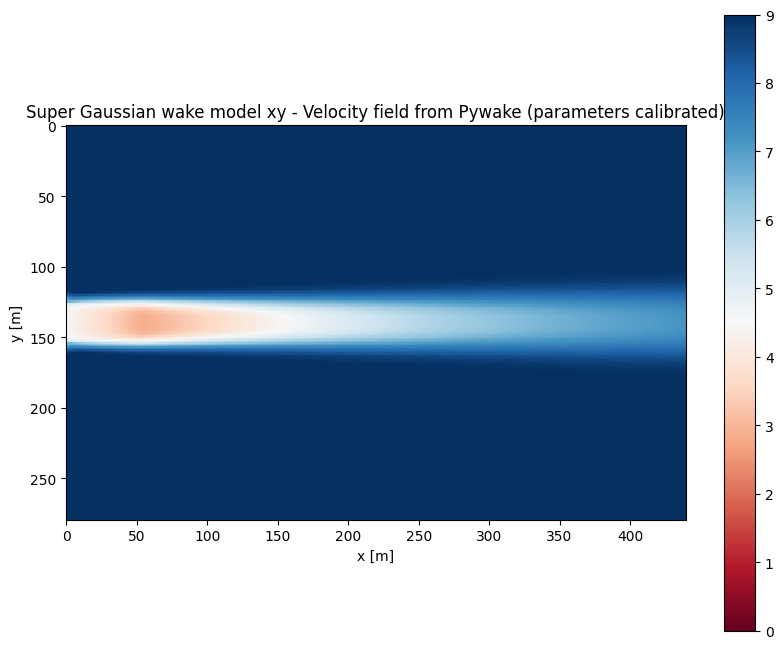

In [18]:
#XY
def objective_function_DE_xy(params):
    b_s, c_s, b_f, c_f = params[0] ,params[1]  ,params[2]  ,params[3]  
    a_s=0
    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()

    
    beta=0.5 * (1+np.sqrt(1-CT))/(np.sqrt(1-CT))
    sigma=(a_s *TI + b_s) * x_tilde_matrix.ravel() + c_s * np.sqrt(beta)
    n = 3.11 * np.exp(b_f * x_tilde) + c_f

    if np.any(sigma < 0) or np.any(n < 2):
        return 10**36
    else:
        result = np.average(abs(velocity_calibr_array -simulation_data_xy.ravel()))
        if math.isnan(result):
            return 10**36
        else:
            return result

initial_params_DE =  None
bounds=np.loadtxt('superG_best_bounds_101_IEA22MW_baseline_new_xy.txt')
bounds_DE = [(bounds[0],bounds[1]),(bounds[2],bounds[3]),(bounds[4],bounds[5]),(bounds[6],bounds[7])]
start_time_DE=time.time()
result_DE = differential_evolution(objective_function_DE_xy, bounds_DE, strategy='best1bin', maxiter=300, popsize=30, tol=0.000001, seed=42, x0=initial_params_DE)
end_time_DE=time.time()
time_DE=end_time_DE-start_time_DE
print(f"Elapsed Time: {time_DE} seconds")
termination_message = result_DE.message
print(f"Termination message: {termination_message}")

optimized_params_DE_xy = result_DE.x
optimal_function_DE_xy = result_DE.fun
print("Best Solution:", optimized_params_DE_xy)
print("Best Objective Value:", optimal_function_DE_xy)
np.savetxt('superG_best_params_101_IEA22MW_baseline_new_xy.txt', optimized_params_DE_xy)
optimal_function_array = np.array([optimal_function_DE_xy])
np.savetxt('superG_best_sol_101_IEA22MW_baseline_new_xy.txt', optimal_function_array)
optimized_params_DE=optimized_params_DE_xy
wf_model_optimized_DE_xy=BlondelSuperGaussianDeficit2020(a_s=0, b_s=optimized_params_DE[0], c_s=optimized_params_DE[1], b_f=optimized_params_DE[2], c_f=optimized_params_DE[3])
velocity_final_DE_xy=get_velocity_field_xy(wf_model_optimized_DE_xy)
fig = plt.figure(figsize=(10, 8))
plt.imshow(velocity_final_DE_xy, cmap='RdBu', interpolation='nearest', vmin=0, vmax=9)
plt.colorbar()  
plt.title('Super Gaussian wake model xy - Velocity field from Pywake (parameters calibrated)')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()





In [19]:
'''#monte carlo analysis as a refinement xy 
NN=5000
stv=0.2
possible_solutions_bs=np.random.normal(0, stv, NN) * optimized_params_DE_xy[0] + optimized_params_DE_xy[0]
possible_solutions_cs=np.random.normal(0, stv, NN) * optimized_params_DE_xy[1] + optimized_params_DE_xy[1]
possible_solutions_bf=np.random.normal(0, stv, NN) * optimized_params_DE_xy[2] + optimized_params_DE_xy[2]
possible_solutions_cf=np.random.normal(0, stv, NN) * optimized_params_DE_xy[3] + optimized_params_DE_xy[3]



best_solution=10**16
for i in range(NN):
    params=[0, possible_solutions_bs[i],possible_solutions_cs[i],possible_solutions_bf[i],possible_solutions_cf[i]]
    error=objective_function_DE_xy(params)
    if error < best_solution:
        best_solution=error
        best_params_MC=params
                        


print('best solution:', best_solution )
print('optimal parameters:',best_params_MC )'''




"#monte carlo analysis as a refinement xy \nNN=5000\nstv=0.2\npossible_solutions_bs=np.random.normal(0, stv, NN) * optimized_params_DE_xy[0] + optimized_params_DE_xy[0]\npossible_solutions_cs=np.random.normal(0, stv, NN) * optimized_params_DE_xy[1] + optimized_params_DE_xy[1]\npossible_solutions_bf=np.random.normal(0, stv, NN) * optimized_params_DE_xy[2] + optimized_params_DE_xy[2]\npossible_solutions_cf=np.random.normal(0, stv, NN) * optimized_params_DE_xy[3] + optimized_params_DE_xy[3]\n\n\n\nbest_solution=10**16\nfor i in range(NN):\n    params=[0, possible_solutions_bs[i],possible_solutions_cs[i],possible_solutions_bf[i],possible_solutions_cf[i]]\n    error=objective_function_DE_xy(params)\n    if error < best_solution:\n        best_solution=error\n        best_params_MC=params\n                        \n\n\nprint('best solution:', best_solution )\nprint('optimal parameters:',best_params_MC )"

differential evolution different objective functions

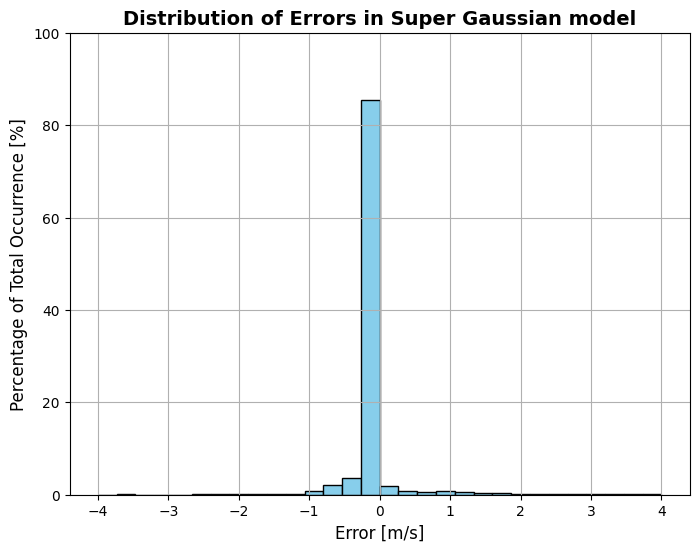

In [10]:
optimal_params= np.loadtxt('superG_best_params_101_IEA22MW_baseline_new_xy.txt')

wf_model_optimized_DE3=BlondelSuperGaussianDeficit2020(a_s=0, b_s=optimal_params[0], c_s=optimal_params[1], b_f=optimal_params[2], c_f=optimal_params[3])
velocity_final_DE3=get_velocity_field_xy(wf_model_optimized_DE3)

errors= (velocity_final_DE3.ravel() - simulation_data_xy.ravel())


plt.figure(figsize=(8, 6))

# Define bins for the histogram, including 0 to separate positive and negative errors
bins = np.linspace(-4, 4, 31)  # 20 bins from -4 to 4

plt.title('Distribution of Errors in Super Gaussian model', fontsize=14, fontweight='bold')
plt.xlabel('Error [m/s]', fontsize=12)
plt.ylabel('Percentage of Total Occurrence [%]', fontsize=12)
plt.grid(True)

# Convert histogram counts to percentages
total_occurrence = len(errors)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
hist_counts, _ = np.histogram(errors, bins=bins)
max_count = len(errors)
hist_percentage = (hist_counts / max_count) * 100

# Plotting the histogram with occurrence in percentage
plt.bar(bin_centers, hist_percentage, width=bins[1] - bins[0], color='skyblue', edgecolor='black')
plt.ylim([0, 100])
plt.show()

Elapsed Time: 694.1761207580566 seconds
Termination message: Optimization terminated successfully.
Best Solution: [ 0.02219703  0.12651159 -0.32636649  3.06858186]
Best Objective Value: 0.837371550722024
If implemented with RMSE the objectie function would be: 0.22835837478883356


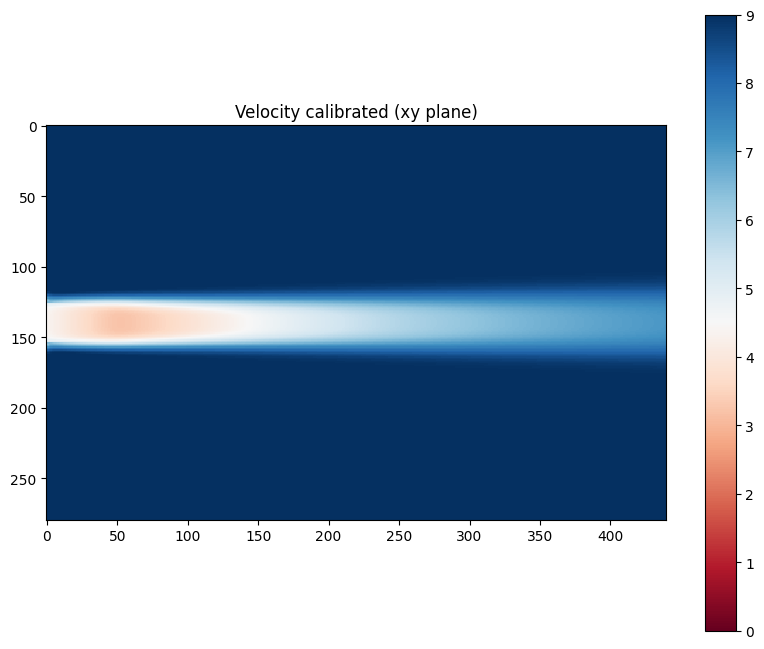

In [21]:
#trying different objective functions
import math

#XY 

def objective_function_DE3_xy(params):
    b_s, c_s, b_f, c_f = params[0]  ,params[1]  ,params[2]  ,params[3]  
    a_s=0
    
    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()

    
    beta=0.5 * (1+np.sqrt(1-CT))/(np.sqrt(1-CT))
    sigma=(a_s *TI + b_s) * x_tilde_matrix.ravel() + c_s * np.sqrt(beta)
    n = 3.11 * np.exp(b_f * x_tilde) + c_f

    if np.any(sigma < 0) or np.any(n < 2):
        return 10**36
    else:
        tot = np.sum((velocity_calibr_array.ravel() - simulation_data_xy.ravel()) ** 2)
        result_DE3 = np.sqrt(tot / len(velocity_calibr_array))
        if math.isnan(result_DE3):
            return 10**36
        else:
            return result_DE3


initial_params_DE3 =  None
bounds = np.loadtxt('superG_best_bounds_101_IEA22MW_baseline_new_xy.txt')
bounds_DE3=[(bounds[0],bounds[1]),(bounds[2],bounds[3]),(bounds[4],bounds[5]),(bounds[6],bounds[7])]

start_time_DE3=time.time()
result_DE3 = differential_evolution(objective_function_DE3_xy, bounds_DE3, strategy='best1bin', maxiter=300, popsize=30, tol=0.000001, seed=42, x0=initial_params_DE3)
end_time_DE3=time.time()
time_DE3=end_time_DE3-start_time_DE3
print(f"Elapsed Time: {time_DE3} seconds")
termination_message = result_DE3.message
print(f"Termination message: {termination_message}")

optimized_params_DE3_xy = result_DE3.x
optimal_function_DE3_xy = result_DE3.fun
print("Best Solution:", optimized_params_DE3_xy)
print("Best Objective Value:", optimal_function_DE3_xy)
optimized_params_DE3arr = np.array([ optimized_params_DE3_xy])
np.savetxt('superG_best_params_101_IEA22MW_baseline_new_xy_DE3.txt', optimized_params_DE3arr)
optimal_function_DE3arr = np.array([ optimal_function_DE3_xy])
np.savetxt('superG_best_sol_101_IEA22MW_baseline_new_xy_DE3.txt', optimal_function_DE3arr)

wf_model_optimized_DE3_xy=BlondelSuperGaussianDeficit2020(a_s=0, b_s=optimized_params_DE3_xy[0], c_s=optimized_params_DE3_xy[1], b_f=optimized_params_DE3_xy[2], c_f=optimized_params_DE3_xy[3])
velocity_final_DE3_xy=get_velocity_field_xy(wf_model_optimized_DE3_xy)

#comparing results with RMSE objective function
tot = np.average(abs(velocity_final_DE3_xy.ravel() -simulation_data_xy.ravel()))
np.savetxt('superG_best_sol_101_IEA22MW_baseline_new_xy_DE3_ifRMSE.txt', np.array([tot]))
print("If implemented with RMSE the objectie function would be:",tot)

fig = plt.figure(figsize=(10, 8))
plt.imshow(velocity_final_DE3_xy , cmap='RdBu', interpolation='nearest',vmin=0,vmax=9)
plt.colorbar()  
plt.title('Velocity calibrated (xy plane)')
plt.show()




simulated annealing

In [22]:
#XY

def objective_function_SA_xy(params):
    b_s, c_s, b_f, c_f = params[0] ,params[1]  ,params[2]  ,params[3]  
    a_s=0
    
    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()
    result = np.average(abs(velocity_calibr_array -simulation_data_xy.ravel()))

    return result
initial_params_SuperG =  None
bounds_SA=[(best_bounds_min_bs_xy,best_bounds_max_bs_xy), (best_bounds_min_cs_xy,best_bounds_max_cs_xy),(best_bounds_min_bf_xy,best_bounds_max_bf_xy),(best_bounds_min_cf_xy,best_bounds_max_cf_xy)]

start_time_SA=time.time()
result_ann = dual_annealing(objective_function_SA_xy, bounds_SA ,maxiter=300,seed=42,x0=initial_params_SuperG)
end_time_SA=time.time()
time_SA=end_time_SA-start_time_SA
print(f"Elapsed Time: {time_SA} seconds")
optimized_params_simulatedann_xy = result_ann.x
optimal_function_simulatedann_xy = result_ann.fun

print("Best Solution:", optimized_params_simulatedann_xy)
print("Best Objective Value:", optimal_function_simulatedann_xy)

wf_model_optimized_simulatedann_xy=BlondelSuperGaussianDeficit2020(a_s=0, b_s=optimized_params_simulatedann_xy[0], c_s=optimized_params_simulatedann_xy[1],
                 b_f=optimized_params_simulatedann_xy[2], c_f=optimized_params_simulatedann_xy[3])
velocity_final_simulatedann_xy=get_velocity_field_xy(wf_model_optimized_simulatedann_xy)




Elapsed Time: 173.88654589653015 seconds
Best Solution: [ 0.02237153  0.1383222  -0.30733625  2.57193149]
Best Objective Value: 0.2276210461473249


genetic algorithm

In [23]:
#genetic algorithm
from sko.GA import GA
bounds_xy= np.loadtxt('superG_best_bounds_101_IEA22MW_baseline_new_xy.txt')


#XY

x_tilde=1/D * np.linspace(0, 5600, 440)
x_tilde_matrix = np.tile(x_tilde, (280, 1))

def objective_function_GA_xy(params):
    b_s, c_s, b_f, c_f = params[0] ,params[1]  ,params[2]  ,params[3] 
    a_s=0
    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()
    beta=0.5 * (1+np.sqrt(1-CT))/(np.sqrt(1-CT))
    sigma=(a_s *TI + b_s) * x_tilde_matrix.ravel() + c_s * np.sqrt(beta)
    n = 3.11 * np.exp(b_f * x_tilde) + c_f

    if np.any(sigma < 0) or np.any(n < 2):
        return 10**36
    else:
        tot = np.average(abs(velocity_calibr_array -simulation_data_xy.ravel()))
        if math.isnan(tot):
            return 10**36
        else:
            return tot
            
bounds=bounds_xy
start_time_GA=time.time()
ga = GA(func=objective_function_GA_xy, n_dim=4, size_pop=30, max_iter=300, prob_mut=0.001, lb=[bounds[0],bounds[2],bounds[4],bounds[6]], ub=[bounds[1],bounds[3],bounds[5],bounds[7]], precision=1e-7)   
best_x_xy, best_y_xy = ga.run()
end_time_GA=time.time()
time_GA=end_time_GA-start_time_GA
print(f"Elapsed Time: {time_GA} seconds")
print('best_x:', best_x_xy, '\n', 'best_y:', best_y_xy) 




Elapsed Time: 602.9745509624481 seconds
best_x: [ 0.02279836  0.14021417 -0.35841981  2.64425481] 
 best_y: [0.22805568]


In [24]:
#differential evolution fixed boundaries

""" def objective_function_DE1(params):
    a_s, b_s, c_s, b_f, c_f = params[0] ,params[1]  ,params[2]  ,params[3]  ,params[4]  

    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)
    velocity_calibr_array = get_velocity_field(model_cal).ravel()
    result = np.average(abs(velocity_calibr_array -simulation_data.ravel()))

    return [result]   
initial_params_DE1 =  None
bounds_DE1 = [(0.15, 0.21), (0.0035, 0.009), (0.15, 0.5), (-0.68, -0.1), (1.95, 2.6)]
start_time_DE1=time.time()
result_DE1 = differential_evolution(objective_function_DE1, bounds_DE1, strategy='best1bin', maxiter=200, popsize=6, tol=0.001, seed=42, x0=initial_params_DE1)
end_time_DE1=time.time()
time_DE1=end_time_DE1-start_time_DE1
print(f"Elapsed Time: {time_DE1} seconds")
termination_message = result_DE1.message
print(f"Termination message: {termination_message}")
optimized_params_DE1 = result_DE1.x
optimal_function_DE1 = result_DE1.fun
print("Best Solution:", optimized_params_DE1)
print("Best Objective Value:", optimal_function_DE1) """

' def objective_function_DE1(params):\n    a_s, b_s, c_s, b_f, c_f = params[0] ,params[1]  ,params[2]  ,params[3]  ,params[4]  \n\n    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)\n    velocity_calibr_array = get_velocity_field(model_cal).ravel()\n    result = np.average(abs(velocity_calibr_array -simulation_data.ravel()))\n\n    return [result]   \ninitial_params_DE1 =  None\nbounds_DE1 = [(0.15, 0.21), (0.0035, 0.009), (0.15, 0.5), (-0.68, -0.1), (1.95, 2.6)]\nstart_time_DE1=time.time()\nresult_DE1 = differential_evolution(objective_function_DE1, bounds_DE1, strategy=\'best1bin\', maxiter=200, popsize=6, tol=0.001, seed=42, x0=initial_params_DE1)\nend_time_DE1=time.time()\ntime_DE1=end_time_DE1-start_time_DE1\nprint(f"Elapsed Time: {time_DE1} seconds")\ntermination_message = result_DE1.message\nprint(f"Termination message: {termination_message}")\noptimized_params_DE1 = result_DE1.x\noptimal_function_DE1 = result_DE1.fun\nprint("Best Soluti

In [25]:
#differential evolution sensitivity analysis for  boundaries

"""def objective_function_DE2(params):
    a_s, b_s, c_s, b_f, c_f = params[0] ,params[1]  ,params[2]  ,params[3]  ,params[4]  

    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)
    velocity_calibr_array = get_velocity_field(model_cal).ravel()
    result = np.average(abs(velocity_calibr_array -simulation_data.ravel()))

    return [result]  
best_objective_value = float('inf') 
initial_params_DE2 =  None

cs_min=[0.155,0.16]
bf_max=[-0.4,-0.2]
cf_min=[1.9,2]
for i in range(len(cs_min)):
    cs_minf=cs_min[i]
    for j in range(len(bf_max)):
        bf_maxf=bf_max[j]
        for k in range(len(cf_min)):
            cf_minf=cf_min[k]
            bounds_DE2 = [(0.15,0.21), (0.0035,0.009), (cs_minf,0.5), (-0.68,bf_maxf), (cf_minf,2.62)]
            result = differential_evolution(objective_function_DE2, bounds_DE2, strategy='best1bin', maxiter=200, popsize=6, tol=0.001, seed=42, x0=initial_params_DE2)
            if result.fun < best_objective_value:
                best_solution = result.x
                best_objective_value = result.fun
                best_bounds= [(0.15,0.21), (0.0035,0.009), (cs_minf,0.5), (-0.68,bf_maxf), (cf_minf,2.62)]





print("Best Solution:", best_solution)
print("Best Objective Value:", best_objective_value)
print("Best Bounds:", best_bounds)

optimized_params__DE2=best_solution
wf_model_optimized_DE2=BlondelSuperGaussianDeficit2020(optimized_params__DE2)

velocity_final_DE2=get_velocity_field(wf_model_optimized_DE2)"""

'def objective_function_DE2(params):\n    a_s, b_s, c_s, b_f, c_f = params[0] ,params[1]  ,params[2]  ,params[3]  ,params[4]  \n\n    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)\n    velocity_calibr_array = get_velocity_field(model_cal).ravel()\n    result = np.average(abs(velocity_calibr_array -simulation_data.ravel()))\n\n    return [result]  \nbest_objective_value = float(\'inf\') \ninitial_params_DE2 =  None\n\ncs_min=[0.155,0.16]\nbf_max=[-0.4,-0.2]\ncf_min=[1.9,2]\nfor i in range(len(cs_min)):\n    cs_minf=cs_min[i]\n    for j in range(len(bf_max)):\n        bf_maxf=bf_max[j]\n        for k in range(len(cf_min)):\n            cf_minf=cf_min[k]\n            bounds_DE2 = [(0.15,0.21), (0.0035,0.009), (cs_minf,0.5), (-0.68,bf_maxf), (cf_minf,2.62)]\n            result = differential_evolution(objective_function_DE2, bounds_DE2, strategy=\'best1bin\', maxiter=200, popsize=6, tol=0.001, seed=42, x0=initial_params_DE2)\n            if result